Import the necessary libraries.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from astropy.io import fits
from astropy.visualization import make_lupton_rgb
import sep

Load data from the FITS file for the f105w HUDF image.

In [3]:
data = fits.getdata("hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits")

# This has to be done since the byte order doesn't match (at least on my computer)
data = data.byteswap(inplace=True).newbyteorder()

Calculate the mean and standard deviation of the data, then use this to create a plot the data.

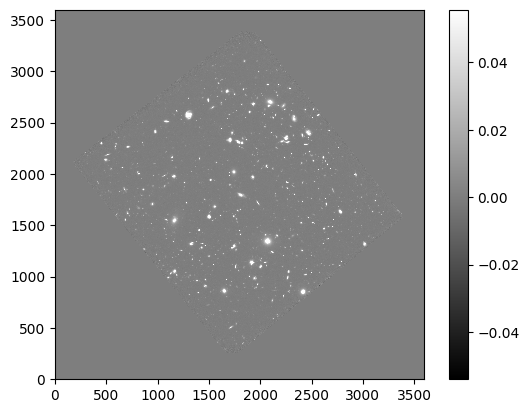

In [4]:
m, s = np.mean(data), np.std(data)
plt.imshow(data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar()

Calculate the background of the data so that it can be subtracted. This is done to increase the accuracy of source detection.

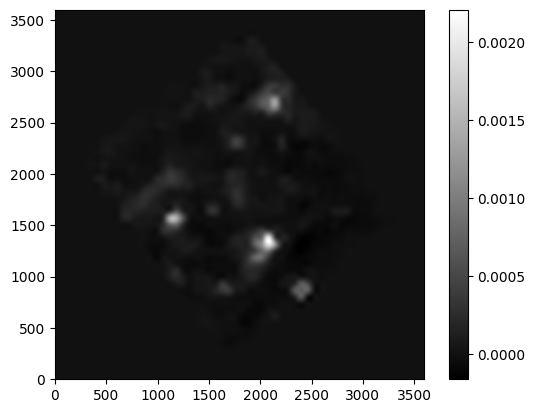

In [5]:
bkg = sep.Background(data)
bkg_image = bkg.back()
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar()

Calculate the background noise level.

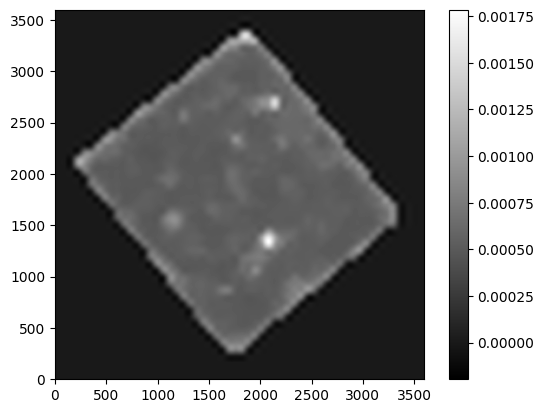

In [6]:
bkg_rms = bkg.rms()
plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar()

Subtract the background from the data.

In [7]:
data_sub = data - bkg

Detect the objects in the resulting image using the background noise as a measurment of error.

In [8]:
objects = sep.extract(data_sub, 1.5, err=bkg.globalrms)

Plot the objects on the image and save the plot as a PNG.

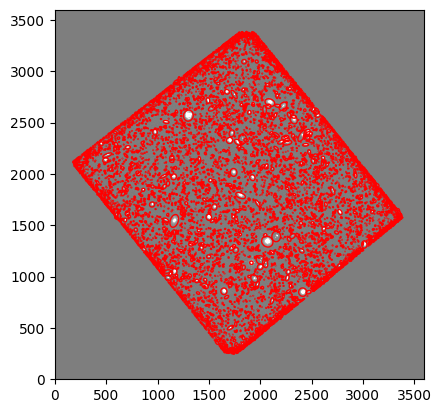

In [9]:
# plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)

Create a list of fluxes and their respective error estimates.

In [10]:
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'],
                                     3.0, err=bkg.globalrms, gain=1.0)

Plot a histogram of the fluxes.

Text(0, 0.5, 'object count')

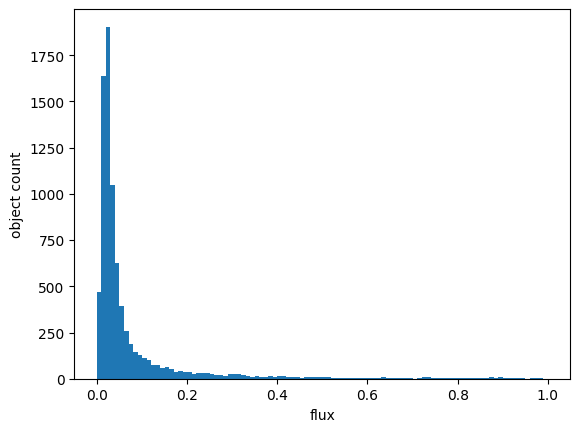

In [19]:
plt.hist(flux, bins=100, range=(0, 1))
plt.xlabel("flux")
plt.ylabel("object count")

Calculate statistics about the flux distribution.

In [30]:
median, mean, std = np.median(flux), np.mean(flux), np.std(flux)
outlier_index = np.argmax(flux)
outlier_std = np.abs(mean - flux[outlier_index]) / std
print("Median flux: %f" % (median))
print("Mean flux: %f" % (mean))
print("Standard deviation: %f" % (std))
print("Largest outlier: %f (%f std from the mean)" % (flux[outlier_index], outlier_std))

Median flux: 0.030955
Mean flux: 0.361747
Standard deviation: 9.241926
Largest outlier: 807.297284 (87.312490 std from the mean)


Load the data from the FITS files for the f125w and f160w images.

In [31]:
data_f125w = fits.getdata("hlsp_hudf12_hst_wfc3ir_udfmain_f125w_v1.0_drz.fits")
data_f125w = data_f125w.byteswap(inplace=True).newbyteorder()
data_f160w = fits.getdata("hlsp_hudf12_hst_wfc3ir_udfmain_f160w_v1.0_drz.fits")
data_f160w = data_f160w.byteswap(inplace=True).newbyteorder()

Create an RGB image using the f160w image for red, the f125w image for blue, and the f105w image for green. Save this image as a PNG file.

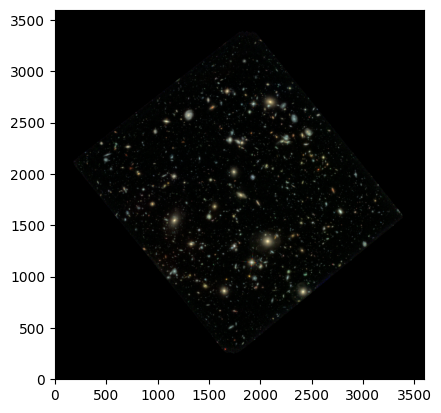

In [32]:
rgb_image = make_lupton_rgb(data_f160w, data_f125w, data, stretch=0.02)
plt.imshow(rgb_image, origin='lower')
plt.savefig("HDF_three_color.png")